# OK Google, google the NASDAQ

## Part I - In the past 5 years...

 ### Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
### Data directory configs
DATA_DIR = './data/'
PLOTS_DIR = './plots_data/'
VIDEO_DIR = './video_data/'

In [3]:
### Load NASDAQ composite index.
df_nasdaq = pd.read_csv(DATA_DIR + 'Composite.csv')
df_nasdaq.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2020-11-02,11010.450195,11924.280273,10830.950195,11895.230469,11895.230469,17973660000
258,2020-11-09,12046.660156,12108.070313,11424.610352,11829.290039,11829.290039,21863210000
259,2020-11-16,11847.110352,11950.179688,11760.980469,11854.969727,11854.969727,23602770000
260,2020-11-23,11916.759766,12236.230469,11796.530273,12205.849609,12205.849609,19465540000
261,2020-11-30,12224.250000,12244.650391,12027.160156,12198.740234,12198.740234,7693430000


Our datasets include stock indexes from 2015/12/01 to 2020/12/01.

The names of columns are quite staightforward. Here we take **NASDAQ Composite** as an example:
+ Date: the first day of every week.
+ Open: the opening price in each week.
+ High: the highest price in each week.
+ Low: the lowest price in each week.
+ Close: the closing price in each week. To be more specific, closing prices on every Friday.

It's noted that **Date** is the first day of the weekly summary rather than the last day. Besides, as we can observe, 2020-11-30 is the first day of the week so the last row of **NASDAQ Composite** dataframe is just the summary of prices for two days (2020/11/30 and 2020/12/01). It's safe to drop it.

In [4]:
# NASDAQ index preprocessing
df_nasdaq['Date'] = pd.to_datetime(df_nasdaq['Date'])
df_nasdaq['Date'] = df_nasdaq['Date'] + pd.Timedelta('6d')  # Adjust the date index to the last day of every week.
df_nasdaq.set_index('Date', inplace=True)  
df_nasdaq = df_nasdaq[0:-1]                                 # Drop the last row.
df_nasdaq.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,11440.639648,11545.629883,10822.570313,10911.589844,10911.589844,17064360000
2020-11-08,11010.450195,11924.280273,10830.950195,11895.230469,11895.230469,17973660000
2020-11-15,12046.660156,12108.070313,11424.610352,11829.290039,11829.290039,21863210000
2020-11-22,11847.110352,11950.179688,11760.980469,11854.969727,11854.969727,23602770000
2020-11-29,11916.759766,12236.230469,11796.530273,12205.849609,12205.849609,19465540000


Now the **NASDAQ Composite** dateset is exactly what we want:

Next, We process Google Trends data (also from 2015/12/01 to 2020/12/01) about topic **Recession**, **NASDAQ**, and **Stock market**.
The tail of the result dataframe matches the previous NASDAQ data.

In [5]:
# Load and process Google Trends data.
# Here we choose 3 categories: NASDAQ, Recession, and Stock market
def process_trends(path, trend_name, new_name):
    df = pd.read_csv(path)
    df.set_index('Week', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.index.set_names('Date', inplace=True)
    df.rename(columns={trend_name: new_name}, inplace=True)
    df[new_name] = df[new_name].apply(lambda x: int(x))
    return df
    
df_nas = process_trends(DATA_DIR + 'NASDAQ_trend.csv', 'NASDAQ: (United States)', 'NASDAQ')
df_rec = process_trends(DATA_DIR + 'Recession_trend.csv', 'Recession: (United States)', 'Recession')
df_stock = process_trends(DATA_DIR + 'Stock_market_trend.csv', 'Stock market: (United States)', 'Stock market')

After the individual processing, all three datesets share the same time index and can be merged perfectly. We first experiment with the closing prices of both stocks.

Let's take a look at the trends for all of them:

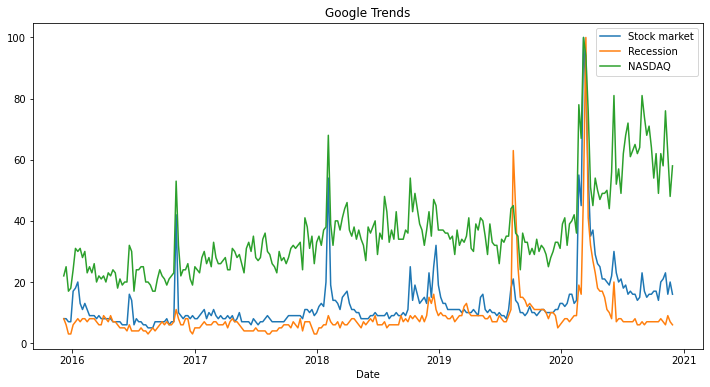

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df_stock, label='Stock market')
plt.plot(df_rec, label='Recession')
plt.plot(df_nas, label='NASDAQ')
plt.title('Google Trends')
plt.xlabel('Date')
plt.legend()

Then we can assemble the target dataframe.

In [7]:
# Generate the merged dataset.
data = pd.DataFrame({'NASDAQ': df_nasdaq['Close'],
                     'trend_NASDAQ': df_nas['NASDAQ'],
                     'trend_recession': df_rec['Recession'],
                     'trend_stock': df_stock['Stock market']})

In [8]:
# data.to_csv(PLOTS_DIR + 'trends_5years.csv')

Next we will extract features and build naive regression models, checking if the Google Trends data decrease the MAE.

### Build the models

The baseline model can be concluded by the formula:

$$y_{t} \sim y_{t-1} + e$$

$y_t$: Closing price of NASDAQ Composite at time $t$.

We now extract the features accordingly. Because there are no features available for the first row, so they need to be dropped.

In [9]:
# Extract features. 
#Because the release of the Google Trends data is later than NASDAQ index, we need to shift the trends data.
data['NASDAQ.l1'] = data['NASDAQ'].shift(1)
data['trend_NASDAQ.l1'] = data['trend_NASDAQ'].shift(1)
data['trend_stock.l1'] = data['trend_stock'].shift(1)
data['trend_recession.l1'] = data['trend_recession'].shift(1)
data.dropna(inplace=True)
data.head()

,NASDAQ,trend_NASDAQ,trend_recession,trend_stock,NASDAQ.l1,trend_NASDAQ.l1,trend_stock.l1,trend_recession.l1
Date,,,,,,,,
2015-12-13,4933.470215,25,6,8,5142.270020,22.0,8.0,8.0
2015-12-20,4923.080078,17,3,7,4933.470215,25.0,8.0,6.0
2015-12-27,5048.490234,18,3,7,4923.080078,17.0,7.0,3.0
2016-01-03,5007.410156,24,6,17,5048.490234,18.0,7.0,3.0
2016-01-10,4643.629883,31,7,18,5007.410156,24.0,17.0,6.0


In [10]:
# Baseline model training. Only use 'NASDAQ.l1' as feature.
X = data[['NASDAQ.l1']]
X = sm.add_constant(X)
y = data['NASDAQ']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NASDAQ   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.778e+04
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          5.46e-240
Time:                        07:39:24   Log-Likelihood:                -1764.1
No. Observations:                 260   AIC:                             3532.
Df Residuals:                     258   BIC:                             3539.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0971     55.930     -0.198      0.8

Old people always say that the stock market is unpredictable. We have learned the same lesson from the paper that we were asked to replicate. 

> As Nelson and Plosser (1982) and many subsequent authors have pointed out, it is very common for macroeconomic data to be represented as a random walk. For a random walk, the best univariate forecast for $y_t$ is simply $yt_1$. 

Let's see if we can gain slightly better $R^2$ by adding Google Trends features.

In [11]:
# With Google Trends data about "NASDAQ" of the last week.
X = data[['NASDAQ.l1', 'trend_NASDAQ.l1']]
X = sm.add_constant(X)
y = data['NASDAQ']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NASDAQ   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     9523.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          9.45e-242
Time:                        07:39:24   Log-Likelihood:                -1754.8
No. Observations:                 260   AIC:                             3516.
Df Residuals:                     257   BIC:                             3526.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -54.1071     54.965     

$R^2$ does increase a little. What about other features? 

In [12]:
# With Google Trends data about "Stock market" in the last week.
X = data[['NASDAQ.l1', 'trend_stock.l1']]
X = sm.add_constant(X)
y = data['NASDAQ']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NASDAQ   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     9692.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.01e-242
Time:                        07:39:24   Log-Likelihood:                -1752.5
No. Observations:                 260   AIC:                             3511.
Df Residuals:                     257   BIC:                             3522.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.2596     53.605     -0.

In [13]:
# With Google Trends data about "Recession" in the last week.
X = data[['NASDAQ.l1', 'trend_recession.l1']]
X = sm.add_constant(X)
y = data['NASDAQ']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NASDAQ   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     9449.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.52e-241
Time:                        07:39:24   Log-Likelihood:                -1755.8
No. Observations:                 260   AIC:                             3518.
Df Residuals:                     257   BIC:                             3528.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.2619     54

A surprising find is that, in the long run (in our case, 5 years), only Google Trends data about NASDAQ, Stock market, and Recession all can bring tiny improvement to the models separately with convincing p-value. Next, we'll take a look at out-of-sample forecasting.

### Out-of-sample forecast

In [14]:
### out-of-sample forecast. Start the rolling window from the 60th row.
start_index = 60
start_date = data.index[start_index]

base = [-1.0] * start_index
stock = [-1.0] * start_index
recession = [-1.0] * start_index
nasdaq = [-1.0] * start_index

# Training for out-sample forecasting. Here we use sklearn lib. 
out_base_model = LinearRegression()
out_stock_model = LinearRegression()
out_recession_model = LinearRegression()
out_nasdaq_model = LinearRegression()

label = 'NASDAQ'
base_features = ['NASDAQ.l1']
stock_features = ['NASDAQ.l1', 'trend_stock.l1']
recession_features = ['NASDAQ.l1', 'trend_recession.l1']
nasdaq_features = ['NASDAQ.l1', 'trend_NASDAQ.l1']

In [15]:
for i in range(start_index, len(data)):
    # Baseline model: use NASDAQ.l1 as the only feature.
    out_base_model.fit(data[:i][base_features], data[:i][label])
    base_pred = out_base_model.predict([data.iloc[i][base_features]])
    base.append(base_pred[0])
    
    # Trends model: use NASDAQ.l1 and Google Trends data in "Stock market" as features.
    out_stock_model.fit(data[:i][stock_features], data[:i][label])
    stock_pred = out_stock_model.predict([data.iloc[i][stock_features]])
    stock.append(stock_pred[0])
    
    # Trends model: use NASDAQ.l1 and Google Trends data in "Recession" as features.
    out_recession_model.fit(data[:i][recession_features], data[:i][label])
    recession_pred = out_recession_model.predict([data.iloc[i][recession_features]])
    recession.append(recession_pred[0])
    
    # Trends model: use NASDAQ.l1 and Google Trends data in "NASDAQ" as features.
    out_nasdaq_model.fit(data[:i][nasdaq_features], data[:i][label])
    nasdaq_pred = out_nasdaq_model.predict([data.iloc[i][nasdaq_features]])
    nasdaq.append(nasdaq_pred[0])

In [16]:
data['base'] = base
data['trend_stock'] = stock
data['trend_recession'] = recession
data['trend_nasdaq'] = nasdaq

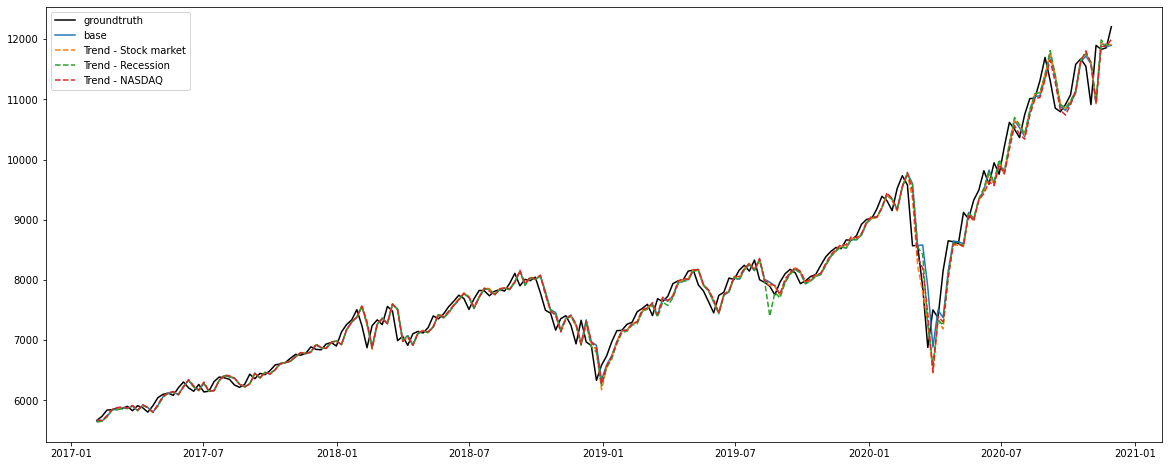

In [17]:
plt.figure(figsize=(20, 8))
plt.plot(data[start_date:][label], 'k', label='groundtruth')
plt.plot(data[start_date:]['base'], label='base')
plt.plot(data[start_date:]['trend_stock'], '--', label='Trend - Stock market')
plt.plot(data[start_date:]['trend_recession'], '--', label='Trend - Recession')
plt.plot(data[start_date:]['trend_nasdaq'], '--', label='Trend - NASDAQ')
plt.legend()

In [18]:
# plot = pd.DataFrame({'label':data[start_date:][label],
#                      'baseline': data[start_date:]['base'], 
#                      'trend_stocke': data[start_date:]['trend_stock'],
#                      'trend_recession': data[start_date:]['trend_recession'],
#                      'trend_nasdaq': data[start_date:]['trend_nasdaq']})
# plot.to_csv(PLOTS_DIR + 'part1_prediction.csv')

The plot above demonstrate the actual NASDAQ index along with the predictions from both baseline model and trends models. Because NASDAQ index basically follows the random walk pattern as we said before, we can hardly tell distinct difference among these plots.

So we need to check MAE for insights.

In [19]:
# Calculate the MAEs and improvements of trends models.
result = data[start_date:]
base_mae = sum(abs(result['base'] - result[label]))/len(result[label])
for col in ['trend_stock', 'trend_recession', 'trend_nasdaq']:
    mae = sum(abs(result[col] - result[label]))/len(result[label])
    improve = (base_mae - mae)/base_mae
    print(f'>>> {col:16s}  MAE:{mae:<10.3f} Improvement:{improve:<10.4f}')

>>> trend_stock       MAE:157.678    Improvement:0.0261    
>>> trend_recession   MAE:162.348    Improvement:-0.0027   
>>> trend_nasdaq      MAE:158.024    Improvement:0.0240    


The calculations tell us Google Trends data about "Stock market" and "NASDAQ" both gain about 2% improvement compared to baseline model. This means it's feasible to do a better prediction for NASDAQ with the help of Google Trends. 

Don't underestimate the value of this 2% improvement. There may be 2,000,000$ behind it!